# Data download

In [2]:
import pandas as pd
import yaml
from pathlib import Path
from scipy.linalg import block_diag
import lightkurve as lk
import numpy as np
import pickle
import astropy.units as u
import matplotlib.pyplot as plt

targets = pd.read_csv("../data/tess-ultra-fast-rotators-brighter-mag14.csv")[
    ["Name", "LS_Period", "Amplitude", "teff_val"]
]
targets = targets.sort_values("LS_Period")


/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/lgrcia/.lightkurve/cache. Please move all the files in the legacy directory /Users/lgrcia/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [49]:
target = targets.iloc[np.argsort(targets["LS_Period"].values)[::-1][4]]
target


Name         4.527934e+08
LS_Period    9.754675e-01
Amplitude    3.120000e-03
teff_val     3.942500e+03
Name: 101, dtype: float64

In [5]:
target = targets.iloc[np.argmin(np.abs(targets.Name - 29923559))]
target


Name         2.992356e+07
LS_Period    5.016226e-01
Amplitude    1.559000e-02
teff_val     3.680700e+03
Name: 21, dtype: float64

In [6]:
targets = targets.sort_values("Amplitude", ascending=False)

In [33]:
target = targets.iloc[0]

In [40]:
def download(target):
    tic = int(target["Name"])
    name = f"TIC {tic}"
    period = target["LS_Period"]

    search_result = lk.search_lightcurve(name, author="SPOC", exptime=120)

    # data
    klc = search_result[0].download()
    times = klc.time.to_value("mjd")
    fluxes = klc.pdcsap_flux.to_value().filled(np.nan)
    errors = klc.flux_err.to_value().filled(np.nan)
    masks = [
        np.isnan(f) | np.isnan(e) | np.isnan(t)
        for f, e, t in zip(fluxes, errors, times)
    ]
    times = [t[~m] for t, m in zip(times, masks)]

    # masking
    time = np.hstack(times)
    time -= np.min(time)
    original_flux = np.hstack([f[~m] for f, m in zip(fluxes, masks)])
    original_error = np.hstack([e[~m] for e, m in zip(errors, masks)])

    flux_median = np.median(original_flux)
    flux = original_flux / flux_median
    error = original_error / flux_median

    url = f"https://exofop.ipac.caltech.edu/tess/download_stellar.php?id={tic}"
    star = pd.read_csv(url, delimiter="|", index_col=1).iloc[0]
    depth = (((1 * u.R_earth) / (star["Radius (R_Sun)"] * u.R_sun)) ** 2).decompose()

    return {
        "flux": flux,
        "time": time,
        "error": error,
        "star_period": float(target.LS_Period),
        "star_amplitude": float(target.Amplitude),
        "star_radius": star["Radius (R_Sun)"],
        "star_mass": star["Mass (M_Sun)"],
    }


In [41]:
data = download(target)

Period: 0.98 days (23.41 hours)
TIC: 452793374
Teff: 3942.500 K


(0.98, 1.02)

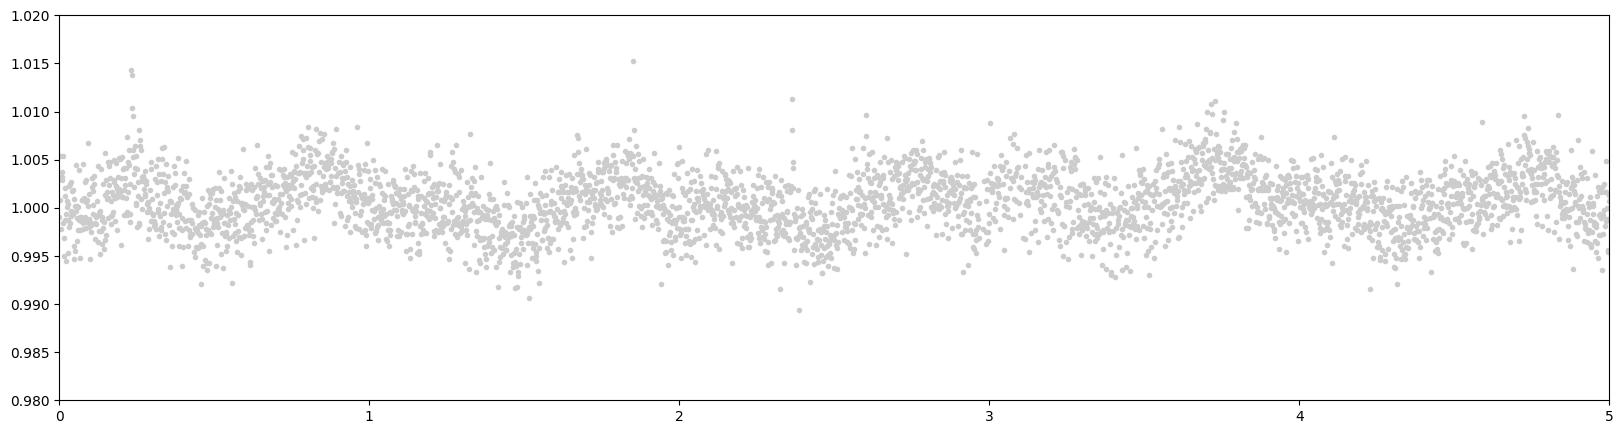

In [42]:
plt.figure(figsize=(20, 5))
plt.plot(data["time"], data["flux"], ".", color="0.8")
print(f"Period: {target['LS_Period']:.2f} days ({target['LS_Period']*24:.2f} hours)")
print(f"TIC: {int(target['Name'])}")
print(f"Teff: {target['teff_val']:.3f} K")
plt.xlim(0, 5)
plt.ylim(0.98, 1.02)

# Parameters

In [50]:
import numpy as np
from nuance.star import Star

star = Star(
    data["star_radius"], data["star_mass"], data["star_amplitude"], data["star_period"]
)

min_period = 0.2
max_period = 10.0
max_snr = 30.0
min_snr = 4.0
# -----

dt = np.median(np.diff(data["time"]))
sigma = np.mean(data["error"])
radii = np.linspace(0.1, 50, 100000)
N = len(data["time"])

max_radius = star.min_radius(max_period, max_snr, N, sigma)
min_radius = star.min_radius(max_period, min_snr, N, sigma)

In [51]:
print(min_radius, max_radius)
print(star.period2tau(max_period), star.period2tau(min_period))
print(star.radius2delta(max_radius), star.radius2delta(min_radius))

4.438312104835181 12.154818285332311
2.2036362751555147 8.118265449219495
2.8057602052240695 21.043201539180522


In [10]:
# min delta
min_radius = radii[
    np.argmin(np.abs([snr(max_period, r, dt, sigma, N) - min_snr for r in radii]))
]
min_depth = (
    (min_radius * u.R_earth) / (star["Radius (R_Sun)"] * u.R_sun)
).decompose().value ** 2
min_delta = target["Amplitude"] / (2 * min_depth)

# min and max tau
min_tau, _ = tau_delta(max_period, -1)
max_tau, _ = tau_delta(min_period, -1)


In [17]:
sigma

0.0042609423

In [16]:
min_depth

0.0012735077751137957

In [11]:
print(min_tau, max_tau)
print(min_delta, max_delta)

0.6659508875634613 2.4533840463313155
3.042776868522648 15


In [368]:
min_depth

0.0012735077751137957

In [362]:
min_depth

0.0012735077751137957

In [358]:
np.linspace(min_delta, max_delta, n)

array([ 3.04277687,  9.02138843, 15.        ])

In [307]:
min_delta

2.118930667681681

In [284]:
(star["Radius (R_Sun)"] * u.R_sun)


<Quantity 0.517266 solRad>

In [ ]:
delta_min

In [267]:
min_depth = target["Amplitude"] / (2 * delta_max)
min_radius = (np.sqrt(min_depth) * star["Radius (R_Sun)"] * u.R_sun).to(u.R_earth).value


In [268]:
min_radius

0.9068487030517299

In [231]:
min_depth

0.058124999999999996

In [210]:
dt = np.median(np.diff(time))
sigma = np.mean(error)
radii = np.linspace(0.1, 50, 3000)
N = len(time)
max_radii = radii[
    np.argmin(
        np.abs([snr(max_period, r, dt, sigma, N) - lower_left_snr for r in radii])
    )
]
min_radii = radii[
    np.argmin(
        np.abs([snr(min_period, r, dt, sigma, N) - lower_right_snr for r in radii])
    )
]


In [211]:
tau_min, delta_min = tau_delta(max_period, max_radii)
tau_max, delta_max = tau_delta(min_period, min_radii)

In [350]:
n = 3
params = np.array(
    np.meshgrid(np.linspace(tau_min, tau_max, n), np.linspace(min_delta, max_delta, n))
)
params = params.reshape(2, n * n)
tau_delta


<function nuance.utils.convert_parameters.<locals>.tau_delta(orbital_period, radius)>

In [351]:
physical_params = np.array([period_radius(*x) for x in params.T])

In [352]:
params

array([[ 0.66595089,  1.55966747,  2.45338405,  0.66595089,  1.55966747,
         2.45338405,  0.66595089,  1.55966747,  2.45338405],
       [ 3.04277687,  3.04277687,  3.04277687,  9.02138843,  9.02138843,
         9.02138843, 15.        , 15.        , 15.        ]])

In [353]:
physical_params

array([[10.        ,  4.02694231],
       [ 0.77844972,  4.02694231],
       [ 0.2       ,  4.02694231],
       [10.        ,  2.33869599],
       [ 0.77844972,  2.33869599],
       [ 0.2       ,  2.33869599],
       [10.        ,  1.81369741],
       [ 0.77844972,  1.81369741],
       [ 0.2       ,  1.81369741]])

In [341]:
params.T

array([[ 0.66595089, 49.34247421],
       [ 1.55966747, 49.34247421],
       [ 2.45338405, 49.34247421],
       [ 0.66595089, 32.17123711],
       [ 1.55966747, 32.17123711],
       [ 2.45338405, 32.17123711],
       [ 0.66595089, 15.        ],
       [ 1.55966747, 15.        ],
       [ 2.45338405, 15.        ]])

In [212]:
print(tau_min, tau_max)
print(delta_min, delta_max)

0.4617445560559378 2.143228375370731
2.2569874867440407 39.69111209531293


In [218]:
snr(*period_radius(tau_max, delta_max), dt, sigma, N)

3.97307994509346

In [202]:
delta_max

39.69111209531293

In [158]:
delta_max

40.77890430875725

In [155]:
params.reshape(2, n * n)


array([[ 0.46174456,  1.30248647,  2.14322838,  0.46174456,  1.30248647,
         2.14322838,  0.46174456,  1.30248647,  2.14322838],
       [ 2.23370187,  2.23370187,  2.23370187, 21.50630309, 21.50630309,
        21.50630309, 40.77890431, 40.77890431, 40.77890431]])

In [157]:
params[1].flatten()

array([ 2.23370187,  2.23370187,  2.23370187, 21.50630309, 21.50630309,
       21.50630309, 40.77890431, 40.77890431, 40.77890431])

In [137]:
tau_min, delta_min

(0.4617445560559378, 2.2337018657128236)

In [64]:
snr(2, 2.0, dt, sigma, N)


6.792402182758839

In [15]:
def snr(tau, delta, P, A, sigma, dt, period):
    D = P / (2 * tau)
    depth = 2 * A / delta
    return depth / sigma * np.sqrt(period * D / dt)


In [16]:
snr(5, 5, target["LS_Period"], target["Amplitude"], sigma, dt, 2.2)

3.4270057826507574

In [17]:
np.sqrt(2.2 * duration / dt) * depth / sigma


3.427005782650757

In [87]:
snr(*period_radius(4, 4), dt, sigma)

1.923077415379554

In [33]:
period_radius()

TypeError: period_radius() missing 2 required positional arguments: 'tau' and 'delta'

In [34]:
from prose import Fluxes

fluxes = Fluxes(time=time, fluxes=flux, errors=error)
fluxes.metadata = {
    "label": f"TIC{int(target['Name'])}",
    "Teff": target["teff_val"],
    "period": target["LS_Period"],
}

fluxes.save(fluxes.metadata["label"] + ".flux")


ModuleNotFoundError: No module named 'prose'

# Intro

We need to pick targets (let say 3) with different properties, and asses how good nuance is compared to a classic TLS. Then, in order to explore the relative depth/duration parameter space of both transit searches, we need to find the smallest (duration and depth) detectable transit. To do that, we need to compute the transit SNR **and** the the white noise of the light curve. Can we rely on the white noise given by TESS?

In [15]:
error

array([0.00468769, 0.00468636, 0.0046805 , ..., 0.00464671, 0.00463994,
       0.00464272], dtype=float32)

don't know...

Let plot a Gaussian process on top of this

In [95]:
import jax

jax.config.update("jax_enable_x64", True)
from tinygp import GaussianProcess
from tinygp.kernels.quasisep import SHO
import jax.numpy as jnp


In [124]:
@jax.jit
def cond():
    cond = gp.condition(flux, time).gp
    return cond.loc, jnp.sqrt(cond.variance)

In [125]:
kernel = SHO(2 * np.pi / period, 10, target["Amplitude"])
gp = GaussianProcess(kernel, time, mean=1.0, diag=error**2)


In [126]:
mu, std = cond()

(0.0, 4.0)

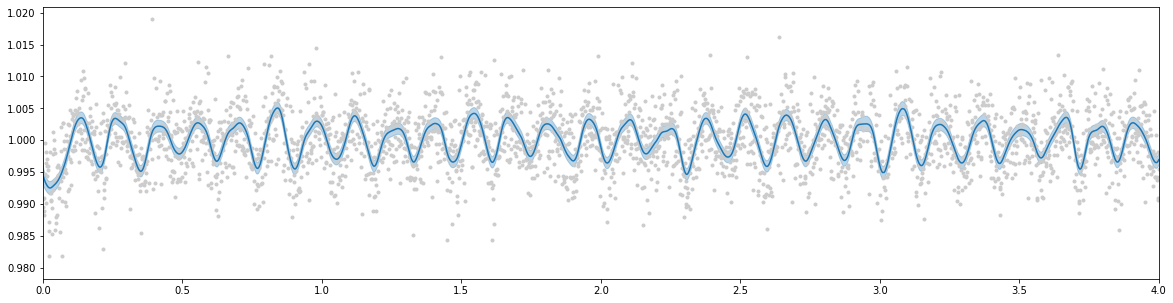

In [129]:
plt.figure(figsize=(20, 5))
plt.plot(time, flux, ".", color="0.8")
plt.plot(time, mu)
plt.fill_between(time, mu + std, mu - std, color="C0", alpha=0.3)
plt.xlim(0, 4)

I don't find this very informative (and it is slow). Let just assume the error is correct)

I will assume that we explore from 0.5 to 10 days periods

None of this is helping. I will just write the code to do the retrieval and try things and see how the recovery looks like and adapt. There is no point trying to come up with the best range of parameters to try.

# Inject & Search

In [7]:
import jax

jax.config.update("jax_enable_x64", True)
from nuance.utils import periodic_transit


/Users/lgrcia/code/dev/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [21]:
transit = 0.005 * periodic_transit(time, 0.0, 0.02, P=2)


In [22]:
from nuance import Nuance
from tinygp import GaussianProcess, kernels

kernel = kernels.quasisep.SHO(2 * np.pi / period, 10, target["Amplitude"])


In [23]:
nu = Nuance(time, flux + transit, error, kernel=kernel)


In [24]:
nu.linear_search(time.copy(), np.array([0.01, 0.02]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17260/17260 [00:05<00:00, 3149.02it/s]


In [25]:
periods = np.linspace(0.5, 3.0, 2000)
search = nu.periodic_search(periods)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:08<00:00,  6.49it/s]


[0.00277782 0.02       1.99949975]


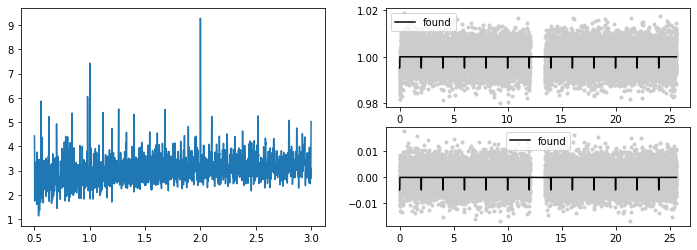

In [26]:
plt.figure(None, (12, 4))


def plot_result(nu, search):
    plt.subplot(2, 2, (1, 3))
    plt.plot(search.periods, search.Q_snr)

    mean, astro, noise = nu.models(*search.best)

    plt.subplot(2, 2, 2)
    plt.plot(nu.time, nu.flux, ".", c="0.8")
    plt.plot(nu.time, astro + 1.0, c="k", label="found")
    _ = plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(nu.time, nu.flux - noise - mean, ".", c="0.8")
    plt.plot(nu.time, astro, c="k", label="found")
    _ = plt.legend()


plot_result(nu, search)
print(search.best)


In [23]:
period

0.1400778

# Syntax

This is an "ideal" syntax I would like to follow

In [88]:
# defining the object
nu = Nuance(time, flux, error, X=X, kernel=kernel)
searches = {}

# scanning the dataset
nu.scan(t0s, durations)
searches[0] = nu.search(periods)

# first transit search
nu = nu.mask(*searches[0].best)
searches[1] = nu.search(periods)

# second transit search
nu = nu.mask(*searches[1].best)
searches[2] = nu.search(periods)

NameError: name 'X' is not defined

(0.0, 5.0)

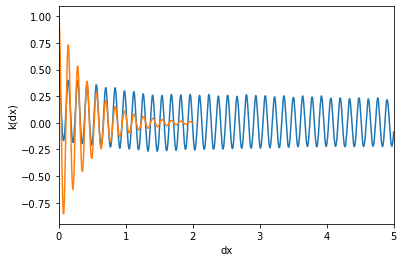

In [42]:
from lib import plot_kernel
import estimators

acor = estimators.autocorr_estimator(time, flux)

lag, power = acor["autocorr"]
plt.figure()
plt.plot(lag, power)
plot_kernel(kernel, lag=np.linspace(0, 2, 800))
plt.xlim(0, 5)


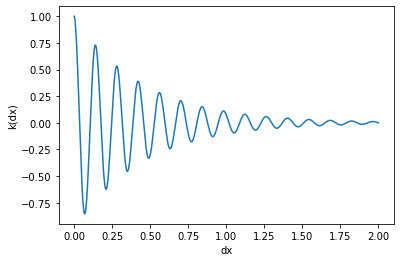

In [37]:
import matplotlib.pyplot as plt

plot_kernel(kernel, lag=np.linspace(0, 2, 800))


In [ ]:
data = LightCurve(time, flux, error, X)

from nuance.kernels import DoubleSHO, optimize

kernel = optimize(DoubleSHO, data)

In [63]:
def build_gp(params, time):
    alpha = 1.0  # jnp.exp(params["log_alpha"])
    short = kernels.quasisep.Matern32(
        sigma=jnp.exp(params["log_sigma_short"]),
        scale=alpha * jnp.exp(params["log_scale_short"]),
    )
    long = kernels.quasisep.Matern32(
        sigma=jnp.exp(params["log_sigma_long"]),
        scale=alpha * jnp.exp(params["log_scale_long"]),
    )
    periodic = kernels.quasisep.SHO(
        omega=jnp.exp(params["log_omega"]),
        quality=jnp.exp(params["log_quality"]),
        sigma=alpha * jnp.exp(params["log_sigma"]),
    )

    kernel = periodic + short + long

    return GaussianProcess(
        kernel, time, diag=jnp.exp(2 * params["log_jitter"]), mean=params["mean"]
    )


In [64]:
from nuance import Nuance

In [65]:
nu = Nuance(time, flux, error)

In [66]:
optimize, mu, nll = nu.gp_optimization(build_gp)

In [108]:
import jax.numpy as jnp

init_params = {
    "log_sigma_short": jnp.log(1e-1),
    "log_scale_short": jnp.log(1e-4),
    "log_sigma_long": jnp.log(1e-1),
    "log_scale_long": jnp.log(1.7e-1),
    "log_omega": jnp.log(2 * jnp.pi / period),
    "log_quality": jnp.log(300),
    "log_sigma": jnp.log(1e-1),
    "log_jitter": jnp.log(np.mean(error)),
    "log_alpha": jnp.log(1.0),
    "mean": 0.0,
}


new_params = init_params
# new_params = optimize(new_params, ["log_sigma_short", "log_sigma_long", "log_sigma", "log_jitter", "mean"])
new_params = optimize(new_params, ["log_quality", "log_omega", "log_jitter"])
# new_params = optimize(new_params)


ScipyMinimizeInfo(fun_val=DeviceArray(-23359.95942616, dtype=float64, weak_type=True), success=False, status=2, iter_num=9)


(0.0, 10.0)

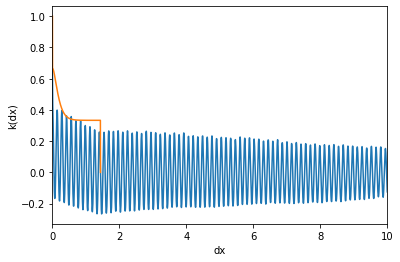

In [109]:
from lib import plot_kernel
import estimators

acor = estimators.autocorr_estimator(time, flux)

lag, power = acor["autocorr"]
plt.figure()
plt.plot(lag, power)
plot_kernel(build_gp(opt, time).kernel, lag=lag)
plt.xlim(0, 10.0)


In [74]:
build_gp(opt, time).kernel

Sum(kernel1=Sum(kernel1=SHO(omega=DeviceArray(82.05054312, dtype=float64), quality=DeviceArray(0.08155685, dtype=float64), sigma=DeviceArray(0.00019637, dtype=float64)), kernel2=Matern32(scale=DeviceArray(9.9999747e-05, dtype=float64), sigma=DeviceArray(0.00059269, dtype=float64))), kernel2=Matern32(scale=DeviceArray(0.03023626, dtype=float64), sigma=DeviceArray(0.00287007, dtype=float64)))